In [1]:
#Importing all the necssary libraries
import pandas as pd
import numpy as np
from collections import Counter
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!pip install wordcloud
from wordcloud import WordCloud

import html
import re
from scipy import stats
import random
random.seed()

import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer

from html.parser import HTMLParser
from bs4 import BeautifulSoup
import unicodedata

import warnings
warnings.filterwarnings("ignore") # To ignore warnings.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Importing all the data into our python notebook, which can be used for further analysis:

In [2]:
generic_tweets = pd.read_csv('generic_tweets.txt')
election_tweets = pd.read_csv('Canadian_elections_2019.csv')
print("Shape of generic_tweets:",generic_tweets.shape)
print("Shape of Canadian Election tweets:",election_tweets.shape)

with open('stop_words.txt','r') as f:
    stop_words = f.read().split('\n')

Shape of generic_tweets: (200000, 6)
Shape of Canadian Election tweets: (2133, 3)


In [3]:
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
election_tweets.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


# 1.Data Cleaning:

### 1.1 Remove HTML tags and attributes and return HTML character codes (i.e., &...;) with an ASCII equivalent
When reading in the CSV files, the HTML tags and character codes are also read in. These symbols are noise to the model as they are not part of the natural language that the sentiment analysis should analyze.

By passing twitter text through BeautifulSoup html parser, the HTML character codes in text are automatically converted into ASCII equivalents, with the HTML tags removed.

This is done by defining a function called parse that takes a line of text and returns it after applying HTML parser to it. The function is applied to each row of the dataframe by the .apply() method.

In [5]:
# defining function to remove HTML tags from all the tweets
def parse(text):
    """
    remove html tags and attributes using beautifulSoup html.parser
    returns output as text
    """
    soup=BeautifulSoup(text,'html.parser')
    return soup.get_text()

In [6]:
# applying the parse function to all rows of the text column.
generic_tweets['text']=generic_tweets['text'].apply(parse)
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
# applying the parse function to all rows of the text column.
election_tweets['text']=election_tweets['text'].apply(parse)
election_tweets.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick & tired of havin..."


### 1.2 Normalize Unicode character with regular text
Some tweets might contain unicode equivalent characters as part of the text, and these character would add noise to the model. To remove this noise, unicodedata.normalize function is used to normalize unicode characters into regular alphabet.

In [8]:
def normalize(text):
    """
    normalizes unicode character to regular text
    Example: normalize('Cześć')='Czesc'
    """
    # read ascii characters using NFKD method, then decode back to string
    text=unicodedata.normalize('NFKD',text).encode('ascii', 'ignore').decode('utf-8')
    return text

In [9]:
# applying the normalize function to all rows of the text column.
generic_tweets['text']=generic_tweets['text'].apply(normalize)
election_tweets['text']=election_tweets['text'].apply(normalize)

### 1.3 Removing the URL
URL within the tweet cannot be processed as by the model, as it is not part of the natural language, and they will be a very low frequency feature in the model..

They are removed using the regular expression operations inside the standard python library.

The re.sub method searches within the string for anything that begins with http or www until a whitespace is seen, and replace all matches with ''.

In [10]:
def remove_URL(text):
    """
    removes URL within a string by matching a pattern
    pattern: http or www until 1st white space seen
    """
    try:
        text = re.sub(r'http\S+', '', text) #match pattern http followed by any non whitespace followed by white space, replace with nothing
        text = re.sub(r'www\S+', '', text)#match pattern www followed by any non whitespace followed by white space, replace with nothing
    except:
        text = text
    return(text)

In [11]:
#removing URL from the tweets
generic_tweets['text']=generic_tweets['text'].apply(remove_URL)
election_tweets['text']=election_tweets['text'].apply(remove_URL)

### 1.4 Removing non letter and white spaces
Also using re.sub to remove none letters and white spaces. This is applied on only generic tweets here, as the airline mentions, identified by a leading @, is not yet stored. This will be applied to the airline tweets after airline mentions are stored.

Non-letters are removed by matching anything that is not in the a-z, A-Z, and white space set, and replacing all matches with a white space.

In [12]:
def remove_nonletter(text):
    """
    matching anything that is not in the a-z, A-Z and white space set, replace with white space
    """
    try:
        text=re.sub(r'[^a-zA-Z ]+', ' ', text)
    except:
        text=text
    return text

In [13]:
def remove_ws(text):
    """
    Removing extra whitespace, make all text lower case, and remove trailing and leading white spaces
    """
    try:
        text=re.sub(r'\s+', ' ', text) #removes extra white space, strip leading and trailing white space
        text=text.lower() #make all text lower case
    except:
        text=text
    return text

In [14]:
#removing white space and non letter from generic_tweets dataframe
generic_tweets['text']=generic_tweets['text'].apply(remove_nonletter)
generic_tweets['text']=generic_tweets['text'].apply(remove_ws)

In [15]:
#removing white space from election_tweets dataframe
election_tweets['text']=election_tweets['text'].apply(remove_ws)

In [16]:
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot a that s a bummer you shoulda got ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can t update his facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan i dived many times for the ball mana...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no it s not behaving at all i...


In [17]:
election_tweets.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@rosiebarton so instead of your suggestion, ..."
1,positive,NaN,"b""#allwomanspacewalk it's real!\n@space_statio..."
2,negative,Economy,"b""#brantford it's going to cost you $94 billio..."
3,positive,NaN,"b""#canada #canadaelection2019 #canadavotes \n#..."
4,negative,Economy,"b""#canada #taxpayers are sick & tired of havin..."


### Function to assign party names based on the hashtags  from the tweets:

In [18]:
# Preprocessor and tokenizer code
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer(stop_words="english")

preprocessor = vectorizer.build_preprocessor()
tokenizer = vectorizer.build_tokenizer()

# Defining the bag_of_words function
def bag_of_words(tw):
      
    unigram_ls = tokenizer(preprocessor(tw))
    
    #Create an empty dictionary
    bag_words = {}
    #Run through tokenized unigram list
    for item in unigram_ls:
        #Check to see if item is already a key in the dictionary
        if item in bag_words.keys():
            #If item already in dictionary as a key, increment key value by 1
            bag_words[item] += 1
        
        else:
            #For item in list, add item as key,set key value to 1
            bag_words[item] = 1
           
    return bag_words



# Defining the party function
def party(tw):

    #create a bag of words dictionary of the inputed tweet
    bag_words = bag_of_words(tw)
    
    #Create lists holding the hashtag words for each of the parties
    liberal_ls = ['realchange','justin','trudeau','liberal','justintrudeau','lpc','teamtrudeau','liberalparty','sophie','trudeau4pm','justin4pm']
    conservative_ls = ['harper','cpc','conservative','stephen','stephenharper', 'conservativeparty','harper4pm']
    ndp_ls = ['tommulcair','tom','mulcair','ndp','thomasmulcair','ready4change','mulcair4pm']
    none_ls = ['greenparty', 'green', 'canadiangreens', 'gpc', 'elizabethmay']
    
    #create intial party dictionary to hold nubmer of times (count) a party's associated keyword occurs
    party_dict = {'NDP':0, 'Liberal':0, 'Conservative':0,'None':0}
    
    for key in bag_words:
        #Check if the key is a keyword in each of the political parties lists
               
        if key in liberal_ls:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party_dict['Liberal'] += bag_words[key]
        
        if key in conservative_ls:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party_dict['Conservative'] += bag_words[key]
        
        if key in ndp_ls:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party_dict['NDP'] += bag_words[key]
        
        if key in none_ls:
            # Increase the count for keywords of that party by the number of times that keyword occurs
            party_dict['None'] += bag_words[key]
            
    #create a new string party variable with default other
    #and update its value based on the party with the most frequency of keywords/hashtags
    party_name = 'None'
    for key in party_dict:
        if party_dict[key] > party_dict[party_name]:
            #update party name value
            party_name = key
    
    
    return party_name

Here, I used the relevant words and hashtags in the tweets that identify to certain political parties. For example if the tweet has something like #liberals, it might be possibly belong to the Liberal Party and soon for others as well.

In [19]:
# Run our Party assignement function through the data set
election_tweets['Party'] = election_tweets['text'].apply(party)
election_tweets.head(10)

,sentiment,negative_reason,text,Party
0,negative,Women Reproductive right and Racism,"b""@rosiebarton so instead of your suggestion, ...",None
1,positive,NaN,"b""#allwomanspacewalk it's real!\n@space_statio...",None
2,negative,Economy,"b""#brantford it's going to cost you $94 billio...",Liberal
3,positive,NaN,"b""#canada #canadaelection2019 #canadavotes \n#...",None
4,negative,Economy,"b""#canada #taxpayers are sick & tired of havin...",None
5,negative,Others,"b""#canadavotes2019 #elxn43 #cdnpoli - facts - ...",None
6,positive,NaN,"b""#cdnmedia #elxn43 #cdnpoli #ppc rocky dong h...",None
7,positive,NaN,"b""#cdnpoli #elxn43 the liberals ++ more than d...",NDP
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\ncanada, don...",None
9,negative,Scandal,"b""#cpckinsellagate\nlet's see the receipts. wh...",None


In [20]:
#removing non letter from election_tweets dataframe
election_tweets['text']=election_tweets['text'].apply(remove_nonletter)

In [21]:
election_tweets.head()

,sentiment,negative_reason,text,Party
0,negative,Women Reproductive right and Racism,b rosiebarton so instead of your suggestion h...,None
1,positive,NaN,b allwomanspacewalk it s real n space station ...,None
2,negative,Economy,b brantford it s going to cost you billion f...,Liberal
3,positive,NaN,b canada canadaelection canadavotes n elxn...,None
4,negative,Economy,b canada taxpayers are sick tired of having...,None


### 1.5 Remove stop words
Using stop word list from the natural language tool kit to remove words that are part of the common speech. These are not keywords that carry unique meaning, thus should be removed from the tweets so that the model can analyze only the keywords within the tweet.

In [22]:
# getting ntlk stop word list into dataframe
from nltk.corpus import stopwords 
stop_words_ntlk=pd.DataFrame(data=list(stopwords.words('english')), columns=['word'])
stop_words_combined=stop_words_ntlk

In [23]:
#removing stop words for generic tweets
generic_tweets['text']=generic_tweets['text'].apply(lambda x : x.split())
generic_tweets['text']=generic_tweets['text'].apply(lambda y : [word for word in y if word not in stop_words_combined.values])
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[switchfoot, bummer, shoulda, got, david, carr..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry,..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[kenichan, dived, many, times, ball, managed, ..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[whole, body, feels, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[nationwideclass, behaving, mad, see]"


In [24]:
#removing stop words for election tweets
election_tweets['text']=election_tweets['text'].apply(lambda x : x.split())
election_tweets['text']=election_tweets['text'].apply(lambda y : [word for word in y if word not in stop_words_combined.values])
election_tweets.head()

,sentiment,negative_reason,text,Party
0,negative,Women Reproductive right and Racism,"[b, rosiebarton, instead, suggestion, agree, c...",None
1,positive,NaN,"[b, allwomanspacewalk, real, n, space, station...",None
2,negative,Economy,"[b, brantford, going, cost, billion, next, yea...",Liberal
3,positive,NaN,"[b, canada, canadaelection, canadavotes, n, el...",None
4,negative,Economy,"[b, canada, taxpayers, sick, tired, hard, earn...",None


### 1.6 Lemmatising
Lemmatising each words within a tweet to return each word to the base or dictionay form of a word. This condenses variations of one word into its base form.

Lemmatising is chosen over stemming as it is usually more precise than Stemming. Stemming is a crude process that removes the end of the word to attempt to return the word to its base form, where as Lemmatization uses a vocabulary and morphological analysis of the word to return it to its base form. Lemmatization is more computationally expensive than stemming, however, given the dataset is small in this analysis, the computation cost is negligable.

In [25]:
# construct lemmatising function

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatising (text):
    x = [lemmatizer.lemmatize(word) for word in text]
    return x

In [26]:
#applying lemmatization to each dataset
import nltk
nltk.download('wordnet')

generic_tweets['text']=generic_tweets.text.apply(lemmatising)
election_tweets['text']=election_tweets.text.apply(lemmatising)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
election_tweets.head()

,sentiment,negative_reason,text,Party
0,negative,Women Reproductive right and Racism,"[b, rosiebarton, instead, suggestion, agree, c...",None
1,positive,NaN,"[b, allwomanspacewalk, real, n, space, station...",None
2,negative,Economy,"[b, brantford, going, cost, billion, next, yea...",Liberal
3,positive,NaN,"[b, canada, canadaelection, canadavotes, n, el...",None
4,negative,Economy,"[b, canada, taxpayer, sick, tired, hard, earne...",None


In [28]:
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[switchfoot, bummer, shoulda, got, david, carr..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry,..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[kenichan, dived, many, time, ball, managed, s..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[nationwideclass, behaving, mad, see]"


# 2.Exploratory Analysis

In [29]:
print(election_tweets['Party'].value_counts(normalize=True));print('\n')
print(election_tweets['Party'].value_counts());print('\n')
print('Total Tweet Count: '+ str(election_tweets['Party'].value_counts().values.sum()))

None            0.686357
Liberal         0.170183
Conservative    0.083919
NDP             0.059541
Name: Party, dtype: float64


None            1464
Liberal          363
Conservative     179
NDP              127
Name: Party, dtype: int64


Total Tweet Count: 2133


From the above total tweet counts we can see that, apart from "None" category, Liberals have most tweets and then comes the Conservative and NDP.

In [30]:
# Printing the total positive and negative sentiments for each of the party:

tmp1=election_tweets[election_tweets.sentiment=='negative'].groupby('Party').sentiment.agg(['count'])
tmp1.columns=['negative']
tmp2=election_tweets[election_tweets.sentiment=='positive'].groupby('Party').sentiment.agg(['count'])
tmp2.columns=['positive']
tmp1=tmp1.join(tmp2).fillna(0)
tmp1['%neg']=tmp1.apply(lambda x: round(int(x['negative'])/(int(x['positive'])+int(x['negative'])),3)*100,axis=1)
tmp1['%pos']=tmp1.apply(lambda x: round(int(x['positive'])/(int(x['positive'])+int(x['negative'])),3)*100,axis=1)
tmp1['total']=tmp1.apply(lambda x: (int(x['positive'])+int(x['negative'])),axis=1)
tmp1=tmp1.sort_values(by=['total'], ascending=False)
tmp2=None
tmp1

,negative,positive,%neg,%pos,total
Party,,,,,
None,643,821,43.9,56.1,1464
Liberal,198,165,54.5,45.5,363
Conservative,126,53,70.4,29.6,179
NDP,39,88,30.7,69.3,127


From the above dataframe, it is clear that the Liberals and NDP have high positive tweets than the Conservative party. Surprisingly, Liberals have almost equal number of positive and negative tweets. Conservatives have the most negative tweets than all others.

### Data Visualization

In [31]:
# visualizing the distribution of the tweets using its length

generic_tweets['length'] = generic_tweets['text'].apply(len)
generic_tweets.head()

,class,id,date,query,user,text,length
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[switchfoot, bummer, shoulda, got, david, carr...",8
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry,...",11
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[kenichan, dived, many, time, ball, managed, s...",10
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire]",6
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[nationwideclass, behaving, mad, see]",4


Text(-0.04, 0.5, 'Frequency')

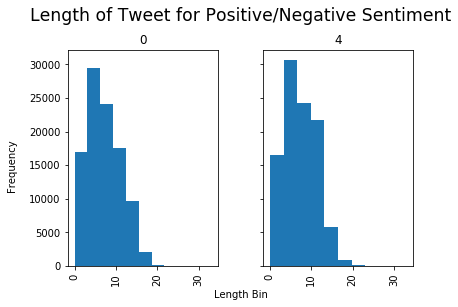

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
generic_tweets.hist('length', by='class', ax=axes)
plt.suptitle('Length of Tweet for Positive/Negative Sentiment', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Length Bin', ha='center')
fig.text(-0.04, 0.5, 'Frequency', va='center', rotation='vertical')

From the above distribution, we can see that almost both the Positive/Negative tweet lengths are almost similar.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026BF413DEF0>]],
      dtype=object)

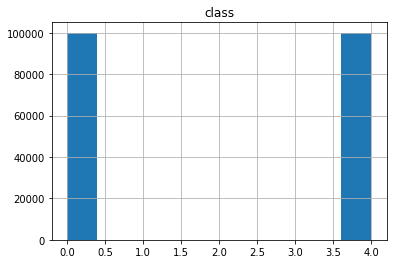

In [33]:
# visualizing how tweets are there for each sentiment
generic_tweets.hist('class')

It is clear that both the classes in the generic tweet data are distributed equally.

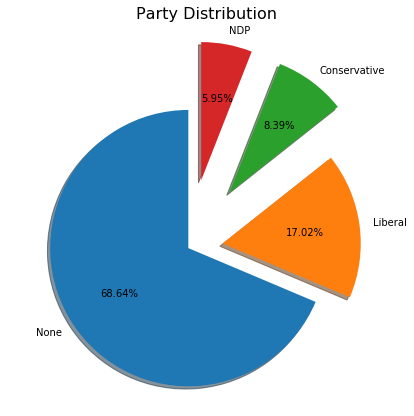

In [34]:
labels = list(election_tweets['Party'].value_counts().keys())
sizes = list(election_tweets['Party'].value_counts().values)
explode = (0, 0.25, 0.5, 0.5) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels,explode=explode, autopct='%1.2f%%', startangle=90, shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.title('Party Distribution', fontsize=16)
plt.show()

In [35]:
# Grouping election tweets by 'party', 'sentiment' 

election_tweets_group2 = election_tweets.groupby(['Party', 'sentiment']).size()
print(election_tweets_group2)

Party         sentiment
Conservative  negative     126
              positive      53
Liberal       negative     198
              positive     165
NDP           negative      39
              positive      88
None          negative     643
              positive     821
dtype: int64


Text(0.5, 1.0, 'Comparison of Positive/Negative Tweets for various parties')

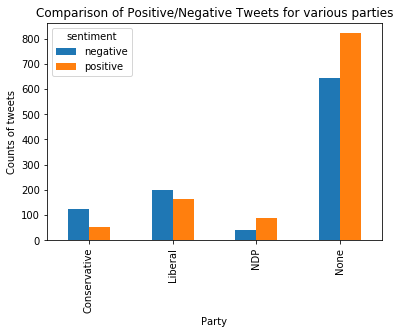

In [36]:
# Comparison of positive/negative reviews for different parties

election_tweets_group2.unstack(fill_value=0).plot.bar()
plt.ylabel('Counts of tweets')
plt.title('Comparison of Positive/Negative Tweets for various parties')

The above plot provides graphical representation of Count of Positive and Negative tweets for each parties.

In [37]:
# filter positive tweets 
generic_tweets_positive = generic_tweets[generic_tweets['class']==4]['text']

# concatenate them into an array 
positive_words = ''
for word in generic_tweets_positive:
    positive_words += str(word)

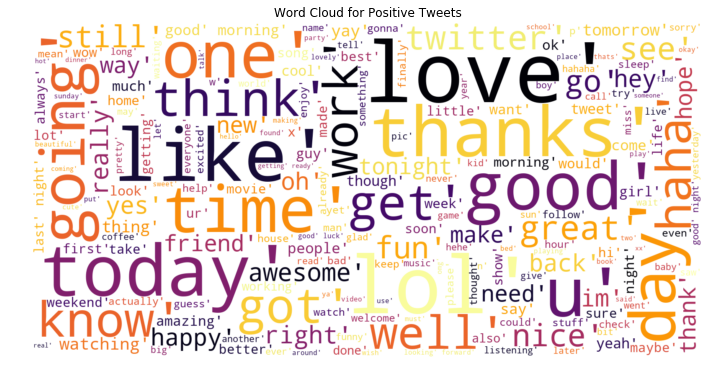

In [38]:
from wordcloud import WordCloud

# show positive words in a wordcloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white', colormap='inferno').generate(positive_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.gca().set_title('Word Cloud for Positive Tweets')
plt.show()

From the above wordcloud, we can see that our function filtered the positive words from the positive tweets. Words such as "good", "love","happy",thanks" and so on are categorized perfectly into positive words.

# 3. Model Preparation

In [39]:
#Importing all the necessary libraries for model preparation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

In [40]:
# function for plotting confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, fs=(12,12),font_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=fs);
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=font_size)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=font_size-2)
    plt.xlabel('Predicted label', fontsize=font_size-2)
    plt.tight_layout()

In [41]:
#defining a function that put back the split tweet text back into a string for countvectorizer
def make_str(text):
    """
    this joins the previously split text back into a string for inputting the text into count vectorizer
    """
    y=''
    for x in text:
        y= y+' '+x
    return y

## Model Preparation using Bag of words (Count Vectorizer):

The model is prepared using the bag of word technique. Count vectorizer converts the tweet texts into a matrix of text tokens.

In [42]:
# make all the tweet text back into a single string, and assign posivie/negative sentiment to class 4/0

generic_tweets_vec=generic_tweets.copy()
generic_tweets_vec.text=generic_tweets_vec.text.apply(make_str)

generic_tweets_vec['sentiment'] = np.where(generic_tweets_vec['class']==4, 'positive', 'negative')

In [43]:
#constructing count vectorizer:

cv = CountVectorizer()
generic_tweets_count = cv.fit_transform(generic_tweets_vec.text) #fitting and transforming the generic tweet text using bag of words.

In [44]:
generic_tweets_count 

<200000x124991 sparse matrix of type '<class 'numpy.int64'>'
	with 1426239 stored elements in Compressed Sparse Row format>

In [45]:
X=generic_tweets_count
y=generic_tweets_vec['sentiment']

#splitting the dataset into training and testing set.
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=101)

## Trying out various classifiers using pipeline for  bag of words:

Here, I compared some of the common classifiers to find which one predicts well.

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=2),
    #SVC(), Computationally expensive because of the size of our spare matrix
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    #XGBClassifier(),  Computationally expensive because of the size of our spare matrix
    #GradientBoostingClassifier(),  Computationally expensive because of the size of our spare matrix
    MultinomialNB()
   ]
for classifier in classifiers:
    pipeline = Pipeline(steps=[('classifier', classifier)])
    pipeline.fit(X_train, y_train) 
    y_pred = pipeline.predict(X_test)
    score = accuracy_score(y_test,y_pred)  
    print(classifier)
    print("Model score: %.3f" % score)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Model score: 0.764
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')
Model score: 0.621
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Model score: 0.695
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_

Out of all the classifiers we used to predict the accuracy on the test set, the Logistic Regression model performs better than others. So we will use the Logistic Regresion Model as our best model.

In [47]:
lg = LogisticRegression()
lg.fit(X_train,y_train)

lg_pred = lg.predict(X_test)

Prediction Accuracy Score: 76.4%


              precision    recall  f1-score   support

    negative       0.77      0.75      0.76     30109
    positive       0.75      0.78      0.77     29891

   micro avg       0.76      0.76      0.76     60000
   macro avg       0.76      0.76      0.76     60000
weighted avg       0.76      0.76      0.76     60000



<Figure size 432x288 with 0 Axes>

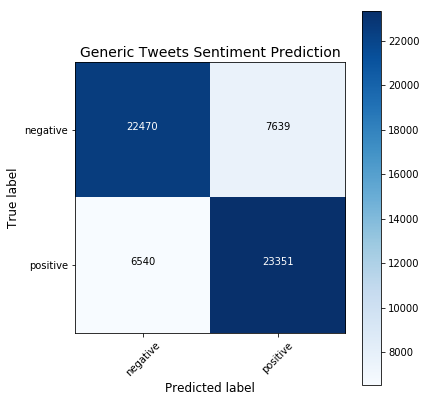

In [48]:
#Predicting the result of the testing set using Bag of words:

print ('Prediction Accuracy Score: ' + str(round(accuracy_score(y_test, lg_pred),3)*100) +'%')
print ('\n')
print(classification_report(y_test,lg_pred))

ticklabel=generic_tweets_vec['sentiment'].unique()
cm=metrics.confusion_matrix(y_test, lg_pred, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Generic Tweets Sentiment Prediction', fs=(6,6), font_size=14)

## Model Preparation using TF-IDF Transformer:

TFIDF transformer is a combination of TF transformer and IDF transformer. The TF transformer finds the frequency of each word that exists within the each tweet string. IDF transformer normalizes this frequency so that words that might have higher frequency because the tweet is longer gets the same weighting as if it was in a shorter tweet.

In [49]:
tf = TfidfTransformer()
generic_tweets_tf = tf.fit_transform(generic_tweets_count)

In [50]:
X=generic_tweets_tf
y=generic_tweets_vec['sentiment']

#splitting the dataset into training and testing set.
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=101)

## Trying out various classifiers using pipeline for TF-IDF model:

Here, I compared some of the common classifiers to find which one predicts well.

In [51]:
#Here, I am not running Support Vector Machines and XGB Classifier because it took very long time to compute the accuracy
#and had very low accuracy than others. So I left those classifiers.

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=2),
    #SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    #XGBClassifier(),
    MultinomialNB()
   ]
for classifier in classifiers:
    pipeline = Pipeline(steps=[('classifier', classifier)])
    pipeline.fit(X_train, y_train)   
    y_pred = pipeline.predict(X_test)
    score = accuracy_score(y_test,y_pred)  
    print(classifier)
    print("Model score: %.3f" % score)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Model score: 0.768
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')
Model score: 0.548
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Model score: 0.699
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_

From the above results we can see that, Logistic Regression gives a better accuracy than all the other classifiers. So, I will be using the Logistic Regression to predict the accuracy.

In [52]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train,y_train)

lg_pred_tf = lg.predict(X_test)

Prediction Accuracy Score: 76.8%


              precision    recall  f1-score   support

    negative       0.79      0.74      0.76     30109
    positive       0.75      0.80      0.77     29891

   micro avg       0.77      0.77      0.77     60000
   macro avg       0.77      0.77      0.77     60000
weighted avg       0.77      0.77      0.77     60000



<Figure size 432x288 with 0 Axes>

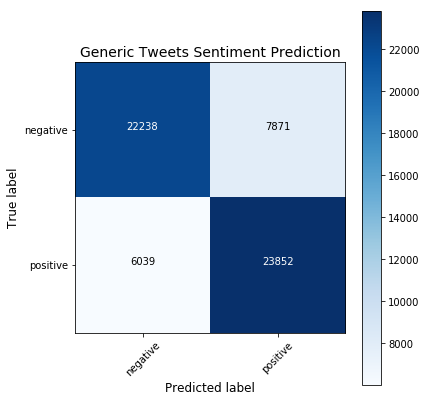

In [53]:
#Predicting the result of the testing set using TF-IDF vectorizer:

print ('Prediction Accuracy Score: ' + str(round(accuracy_score(y_test, lg_pred_tf),3)*100) +'%')
print ('\n')
print(classification_report(y_test,lg_pred_tf))

ticklabel=generic_tweets_vec['sentiment'].unique()
cm=metrics.confusion_matrix(y_test, lg_pred_tf, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Generic Tweets Sentiment Prediction', fs=(6,6), font_size=14)

From the above results, we can see that the accuracy of the TF-IDF model was slightly more than the accuracy of the Bag of words model. So, I will be using the TF-IDF model on the election tweets to predict the sentiment of it.

# 4. Model Implementation

### 4.1 Evaluating Election Model with  Generic Tweets Model :

In [54]:
election_tweets_vec=election_tweets.copy()
election_tweets_vec.text=election_tweets_vec.text.apply(lambda x : make_str(x))

In [55]:
election_tweets_count = cv.transform(election_tweets_vec.text)
election_tweets_tf1 = tf.transform(election_tweets_count)

Applying the generic tweet logistic regression model to the Election tweet data:

In [56]:
y_pred_election=lg.predict(election_tweets_tf1)

Prediction Accuracy Score: 60.0%
              precision    recall  f1-score   support

    negative       0.61      0.42      0.50      1006
    positive       0.59      0.76      0.67      1127

   micro avg       0.60      0.60      0.60      2133
   macro avg       0.60      0.59      0.58      2133
weighted avg       0.60      0.60      0.59      2133



<Figure size 432x288 with 0 Axes>

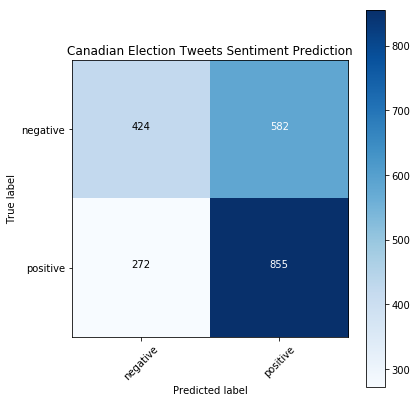

In [57]:
# presenting the result of the model predictions
ticklabel=election_tweets_vec.sentiment.unique()
cm=metrics.confusion_matrix(election_tweets_vec.sentiment, y_pred_election, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Canadian Election Tweets Sentiment Prediction', fs=(6,6), font_size=12)
print ('Prediction Accuracy Score: '+str((round(accuracy_score(election_tweets_vec.sentiment, y_pred_election),3))*100)+'%')
print(classification_report(election_tweets_vec.sentiment, y_pred_election))

Our generic tweet model applied to the election tweet model, was able to get an accuracy of 60%. I would say our model did a good job because, it was trained on the generic tweet data and tested on a completely new data. Moving forward, we could futher refine our model using hyper parameter tuning.

## BONUS

### Tried out n_grams feature tuning:

In [58]:
n_grams=[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]

for x in n_grams:
    cv_1=CountVectorizer(ngram_range=(x))
    tf = TfidfTransformer()

    generic_tweets_n_grams=generic_tweets.copy()
    generic_tweets_n_grams.text=generic_tweets_n_grams.text.apply(make_str)
    generic_tweets_n_grams['sentiment'] = np.where(generic_tweets_n_grams['class']==4, 'positive', 'negative')
    generic_count=cv_1.fit_transform(generic_tweets_n_grams.text)
    generic_tf = tf.fit_transform(generic_count)
    X=generic_tf
    y=generic_tweets_n_grams['sentiment']
    
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=101,shuffle = True)

    model_ngrams=LogisticRegression(random_state=42)
    model_ngrams.fit(X_train,y_train)
    y_pred=model_ngrams.predict(X_test)

    print ('Generic Tweets Test Set Accuracy: ' + str(round(accuracy_score(y_test, y_pred),3))+' x:' +str(x))

    election_tweets_n_grams=election_tweets.copy()
    election_tweets_n_grams.text=election_tweets_n_grams.text.apply(make_str)

    election_count=cv_1.transform(election_tweets_n_grams.text)
    election_tf = tf.transform(election_count)

    y_pred_election_n_grams=model_ngrams.predict(election_tf)
    print ('Election Tweet Prediction Accuracy: ' + str(round(accuracy_score(election_tweets_vec.sentiment, y_pred_election_n_grams),3))+' x:' +str(x))
    print ('\n')

Generic Tweets Test Set Accuracy: 0.768 x:(1, 1)
Election Tweet Prediction Accuracy: 0.6 x:(1, 1)


Generic Tweets Test Set Accuracy: 0.771 x:(1, 2)
Election Tweet Prediction Accuracy: 0.603 x:(1, 2)


Generic Tweets Test Set Accuracy: 0.768 x:(1, 3)
Election Tweet Prediction Accuracy: 0.595 x:(1, 3)


Generic Tweets Test Set Accuracy: 0.681 x:(2, 2)
Election Tweet Prediction Accuracy: 0.571 x:(2, 2)


Generic Tweets Test Set Accuracy: 0.678 x:(2, 3)
Election Tweet Prediction Accuracy: 0.571 x:(2, 3)


Generic Tweets Test Set Accuracy: 0.555 x:(3, 3)
Election Tweet Prediction Accuracy: 0.529 x:(3, 3)




Using n_grams feature we were able to increase the acccuracy of our model from 60% to 60.3% which might not look like a major improvement, but it might help our model to predict better sentiment results. Since the election tweet model has very less data compared to generic tweets, the model was able to grasp every detail from the data.

## Hyper parameter tuning of Logistic Regression: C

In [59]:
C_range=[1,3,5,7,9,11]
generic=[]
election=[]
for x in C_range:
    cv_2=CountVectorizer(ngram_range=(1,2))
    tf = TfidfTransformer()

    generic_tweets_c_params=generic_tweets.copy()
    generic_tweets_c_params.text=generic_tweets_c_params.text.apply(make_str)
    generic_tweets_c_params['sentiment'] = np.where(generic_tweets_c_params['class']==4, 'positive', 'negative')
    generic_count=cv_2.fit_transform(generic_tweets_c_params.text)
    generic_tf = tf.fit_transform(generic_count)
    
    X=generic_tf
    Y=generic_tweets_c_params['sentiment']
    
    
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=101)

    model_c_params=LogisticRegression(C=x, random_state=0)
    model_c_params.fit(X_train,y_train)
    y_pred=model_c_params.predict(X_test)
    
    print ('Generic Tweets Test Set Accuracy: ' + str(round(accuracy_score(y_test, y_pred),3))+' C_param:' +str(x))
    generic.append(round(accuracy_score(y_test, y_pred),3))
    
    election_tweets_c_params=election_tweets.copy()
    election_tweets_c_params.text=election_tweets_c_params.text.apply(make_str)

    election_count=cv_2.transform(election_tweets_c_params.text)
    election_tf = tf.transform(election_count)

    y_pred_election_c_params=model_c_params.predict(election_tf)
    
    print ('Election Tweet Prediction Accuracy: ' + str(round(accuracy_score(election_tweets_vec.sentiment, y_pred_election_c_params),3))+' C_param:' +str(x))
    election.append(round(accuracy_score(election_tweets_vec.sentiment, y_pred_election_c_params),3))
    
    print ('\n')

Generic Tweets Test Set Accuracy: 0.771 C_param:1
Election Tweet Prediction Accuracy: 0.603 C_param:1


Generic Tweets Test Set Accuracy: 0.775 C_param:3
Election Tweet Prediction Accuracy: 0.61 C_param:3


Generic Tweets Test Set Accuracy: 0.775 C_param:5
Election Tweet Prediction Accuracy: 0.609 C_param:5


Generic Tweets Test Set Accuracy: 0.774 C_param:7
Election Tweet Prediction Accuracy: 0.611 C_param:7


Generic Tweets Test Set Accuracy: 0.774 C_param:9
Election Tweet Prediction Accuracy: 0.614 C_param:9


Generic Tweets Test Set Accuracy: 0.774 C_param:11
Election Tweet Prediction Accuracy: 0.613 C_param:11




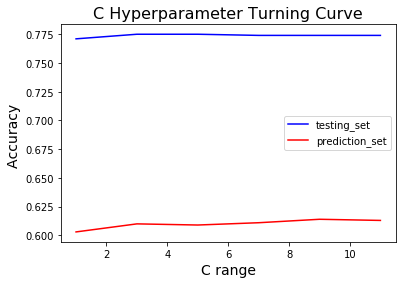

In [60]:
test_set,=plt.plot(C_range, generic, color='blue', label='testing_set')
prediction_set,=plt.plot(C_range, election, color='red', label='prediction_set')
plt.title('C Hyperparameter Turning Curve', fontsize=16)
plt.xlabel('C range',fontsize=14)
plt.ylabel('Accuracy ',fontsize=14)
plt.legend()
plt.show()

I took 'C' as my hyperparameter for the Logistic Regression model, and tried to tune it using a wide range of values and predicted the accuracy with each and every value. From the above plot, we can see that our model accuracy on prediction data increases to 61.4% from 60% at C=9.

Performing more hyperparameter tuning can really fine tune our model to predict well on the election tweet data.

## 4.2

### Election tweet Multi class Logistic Regression model:

In [61]:
election_tweets_neg=election_tweets_vec[election_tweets_vec.sentiment=='negative']

In [62]:
election_tweets_neg.negative_reason.value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

In [63]:
cv_multi=CountVectorizer()
tf_multi = TfidfTransformer()

election_tweets_neg_count=cv_multi.fit_transform(election_tweets_neg.text)
election_tweet_neg_tf = tf_multi.fit_transform(election_tweets_neg_count)

election_tweet_neg_tf.shape

(1006, 4930)

In [64]:
#splitting the dataset into testing and training data
X_multi=election_tweet_neg_tf
Y_multi=election_tweets_neg[election_tweets_neg.sentiment=='negative'].negative_reason

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = train_test_split(X_multi,Y_multi,test_size=0.3, random_state=101)

## Tried out various classifiers using pipeline:

In [65]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    MultinomialNB()
   ]
for classifier in classifiers:
    pipeline = Pipeline(steps=[('classifier', classifier)])
    pipeline.fit(X_multi_train, Y_multi_train)   
    y_pred_multi = pipeline.predict(X_multi_test)
    score = accuracy_score(Y_multi_test,y_pred_multi)  
    print(classifier)
    print("Model score: %.3f" % score)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Model score: 0.404
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
Model score: 0.427
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Model score: 0.377


From the above accuracy results, we can see that KNeighbour Classifier was able to predict the test data with higher accuracy than others. So, I will be using KNN model on the multiclass data for further analysis.

In [66]:
# construct an instance of KNeighbours Classifier
model_multi = KNeighborsClassifier()
model_multi.fit(X_multi_train, Y_multi_train)

y_multi_predict = model_multi.predict(X_multi_test)

Prediction Acuracy: 42.699999999999996%
                                     precision    recall  f1-score   support

                    Climate Problem       0.80      0.24      0.36        17
                            Economy       0.57      0.53      0.55        15
                         Healthcare       0.00      0.00      0.00         3
                             Others       0.39      0.70      0.50        94
                          Privilege       0.00      0.00      0.00         2
                            Scandal       0.44      0.39      0.41        93
                         Separation       1.00      0.20      0.33         5
                          Tell lies       0.43      0.16      0.23        63
Women Reproductive right and Racism       0.50      0.40      0.44        10

                          micro avg       0.43      0.43      0.43       302
                          macro avg       0.46      0.29      0.32       302
                       weighted av

<Figure size 432x288 with 0 Axes>

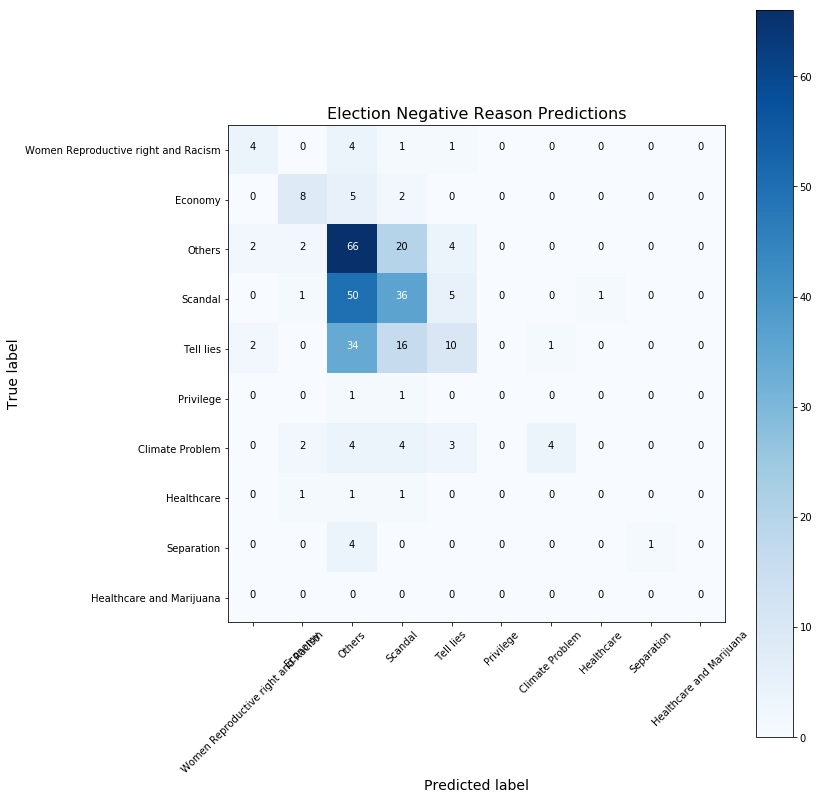

In [67]:
ticklabel=election_tweets_neg[election_tweets_neg.sentiment=='negative'].negative_reason.unique()
cm=metrics.confusion_matrix(Y_multi_test, y_multi_predict, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Election Negative Reason Predictions', fs=(12,12), font_size=16)
print ('Prediction Acuracy: '+str(round(accuracy_score(Y_multi_test, y_multi_predict),3)*100)+'%')
print(classification_report(Y_multi_test,y_multi_predict))

## Reason for combining some of negative reasons:

Here, I combined some of the negative reasons into one another because of the following reasons.
I combined "Separation" and "Privilege" into "Women Reproductive right and Racism" because, I felt Racism and Separation had a similar connection between them and Womens Reproductive right and Privilege had similar connection.
I combined "Healthcare and Marijuana" grouped to "Healthcare" because both of them deal with healthcare stuff. 
Scandal and Tell lies are similar to each other because they deal with almost similar ideology, so I combined them together.
Climate Problem obviously affects the Economy in one way or other, so I combined both of them.

In [68]:
election_tweets_neg['negative_reason'] = election_tweets_neg['negative_reason'].str.replace("Separation","Women Reproductive right and Racism")
election_tweets_neg['negative_reason'] = election_tweets_neg['negative_reason'].str.replace("Healthcare and Marijuana","Healthcare")
election_tweets_neg['negative_reason'] = election_tweets_neg['negative_reason'].str.replace("Healthcare","Others")
election_tweets_neg['negative_reason'] = election_tweets_neg['negative_reason'].str.replace("Tell lies","Scandal")
election_tweets_neg['negative_reason'] = election_tweets_neg['negative_reason'].str.replace("Climate Problem","Economy")
election_tweets_neg['negative_reason'] = election_tweets_neg['negative_reason'].str.replace("Privilege","Women Reproductive right and Racism")

In [69]:
election_tweets_neg.negative_reason.value_counts()

Scandal                                468
Others                                 373
Economy                                 92
Women Reproductive right and Racism     73
Name: negative_reason, dtype: int64

After combining, I reduced the negative reasons from 10 categories to 4 categories, so that it might help our multi class model to improve the accuracy.

In [70]:
cv_multi1=CountVectorizer()
tf_multi1 = TfidfTransformer()

election_tweets_neg_count1=cv_multi1.fit_transform(election_tweets_neg.text)
election_tweet_neg_tf1 = tf_multi1.fit_transform(election_tweets_neg_count)

In [71]:
#splitting the dataset into testing and training data
X_multi=election_tweet_neg_tf1
y_multi=election_tweets_neg[election_tweets_neg.sentiment=='negative'].negative_reason

X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X_multi,y_multi,test_size=0.3, random_state=101)

In [72]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    MultinomialNB()
   ]
for classifier in classifiers:
    pipeline = Pipeline(steps=[('classifier', classifier)])
    pipeline.fit(X_multi_train, y_multi_train)   
    y_pred_multi = pipeline.predict(X_multi_test)
    score = accuracy_score(y_multi_test,y_pred_multi)  
    print(classifier)
    print("Model score: %.3f" % score)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Model score: 0.570
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
Model score: 0.556
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Model score: 0.556


After combining, some of the negative reasons the Logistic Regression model gave better accuracy than other classifiers. So, I will be using the Logistic Regression model a my classifier to predict the accuracy.

In [73]:
# construct an instance of logistic regression function
lg_multi = LogisticRegression()
lg_multi.fit(X_multi_train, y_multi_train)

y_multi_predict = lg_multi.predict(X_multi_test)

Prediction Acuracy: 56.99999999999999%
                                     precision    recall  f1-score   support

                            Economy       1.00      0.03      0.06        32
                             Others       0.46      0.52      0.49        97
                            Scandal       0.62      0.77      0.69       156
Women Reproductive right and Racism       1.00      0.06      0.11        17

                          micro avg       0.57      0.57      0.57       302
                          macro avg       0.77      0.34      0.34       302
                       weighted avg       0.63      0.57      0.53       302



<Figure size 432x288 with 0 Axes>

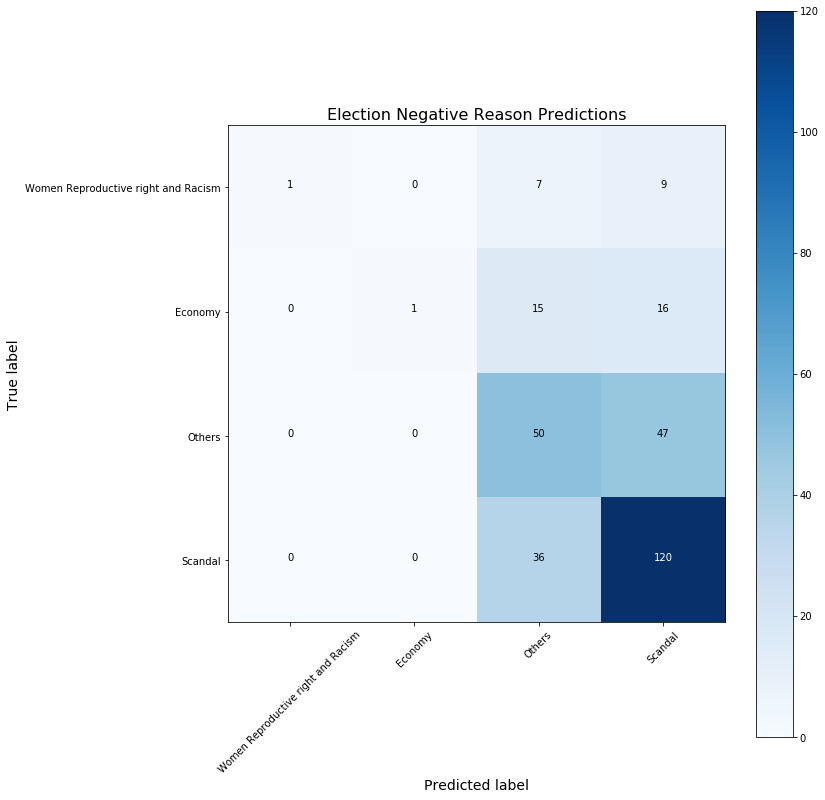

In [74]:
ticklabel=election_tweets_neg[election_tweets_neg.sentiment=='negative'].negative_reason.unique()
cm=metrics.confusion_matrix(y_multi_test, y_multi_predict, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Election Negative Reason Predictions', fs=(12,12), font_size=16)
print ('Prediction Acuracy: '+str(round(accuracy_score(y_multi_test, y_multi_predict),3)*100)+'%')
print(classification_report(y_multi_test,y_multi_predict))

## Bonus: ngrams for Multi Class model:

In [75]:
n_grams=[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]

for x in n_grams:
    
    cv_multi_n=CountVectorizer(ngram_range=(x))
    tfidf_multi_c = TfidfTransformer()

    election_tweets_neg_text=cv_multi_n.fit_transform(election_tweets_neg.text)
    election_neg_trans = tfidf_multi_c.fit_transform(election_tweets_neg_text)
    X_multi=election_neg_trans
    Y_multi=election_tweets_neg[election_tweets_neg.sentiment=='negative'].negative_reason

    X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = train_test_split(X_multi,Y_multi,test_size=0.3, random_state=101)
    model_multi_n_grams = LogisticRegression()
    model_multi_n_grams.fit(X_multi_train, Y_multi_train)
    y_multi_predict_n = model_multi_n_grams.predict(X_multi_test)
    print ('Accuracy Score of Multi class model : '+ str(round(accuracy_score(Y_multi_test, y_multi_predict_n),3))+' N='+str(x))

Accuracy Score of Multi class model : 0.57 N=(1, 1)
Accuracy Score of Multi class model : 0.556 N=(1, 2)
Accuracy Score of Multi class model : 0.543 N=(1, 3)
Accuracy Score of Multi class model : 0.507 N=(2, 2)
Accuracy Score of Multi class model : 0.513 N=(2, 3)
Accuracy Score of Multi class model : 0.52 N=(3, 3)


It is pretty clear from the above results, that multi class models does a good job with (1,1) ngrams only and the accuracy decreases with the increase in ngrams.

## Bonus: Hyperparameter Tuning for Multi Class model

In [76]:
C_param=[1,3,5,7,9,11]
accuracy_multi=[]
for x in C_param:
    
    cv_multi_c=CountVectorizer(ngram_range=(1,1))
    tfidf_multi_c = TfidfTransformer()

    election_tweets_neg_text=cv_multi_c.fit_transform(election_tweets_neg.text)
    election_neg_trans = tfidf_multi_c.fit_transform(election_tweets_neg_text)
    X_multi=election_neg_trans
    Y_multi=election_tweets_neg[election_tweets_neg.sentiment=='negative'].negative_reason

    X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = train_test_split(X_multi,Y_multi,test_size=0.3, random_state=101)
    model_multi_c = LogisticRegression(C=x)
    model_multi_c.fit(X_multi_train, Y_multi_train)
    y_multi_predict_c = model_multi_c.predict(X_multi_test)
    print ('Accuracy Score: '+ str(round(accuracy_score(Y_multi_test, y_multi_predict_c),3))+' C='+str(x))
    accuracy_multi.append(round(accuracy_score(Y_multi_test, y_multi_predict_c),3))

Accuracy Score: 0.57 C=1
Accuracy Score: 0.589 C=3
Accuracy Score: 0.579 C=5
Accuracy Score: 0.579 C=7
Accuracy Score: 0.57 C=9
Accuracy Score: 0.573 C=11


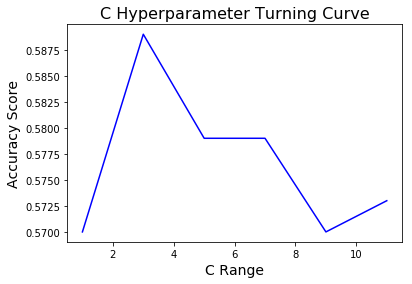

In [77]:
a,=plt.plot(C_param, accuracy_multi, color='blue')
plt.title('C Hyperparameter Turning Curve', fontsize=16)
plt.xlabel('C Range',fontsize=14)
plt.ylabel('Accuracy Score',fontsize=14)
plt.show()

From the above hyperparameter plot, we can see that the accuracy of our model increases when the C value is 3, and it decreases afterwards. It almost increased from 57% to 58.9% which is actually a good increment.

Further hypertuning the model might produce better results on the test data.

# 5. DISCUSSIONS

### 5.1 What can public opinion on Twitter tell us about Canadian Elections 2019?

Canadian Election Tweet Prediction Result Summary


Predictions,negative,positive,% Negative,% Positive,Total
Party,,,,,
None,495,969,33.8,66.2,1464
Liberal,108,255,29.8,70.2,363
Conservative,61,118,34.1,65.9,179
NDP,32,95,25.2,74.8,127


Canadian Election Tweet Sentiment Prediction Report

              precision    recall  f1-score   support

    negative       0.61      0.42      0.50      1006
    positive       0.59      0.76      0.67      1127

   micro avg       0.60      0.60      0.60      2133
   macro avg       0.60      0.59      0.58      2133
weighted avg       0.60      0.60      0.59      2133



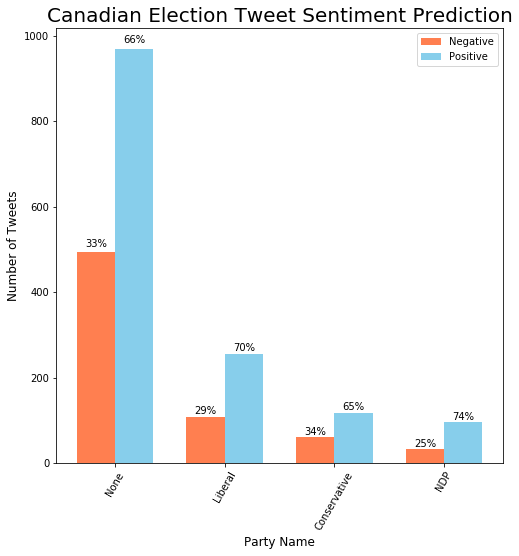

In [78]:
x = {'Party': election_tweets_vec.Party, 'Predictions': y_pred_election, 'dummy':'1'}
election_prediction = pd.DataFrame(data=x)
x = pd.pivot_table(election_prediction, values='dummy', index=['Party'], columns=['Predictions'], aggfunc='count')
x['% Negative']=x.apply(lambda x: round(int(x['negative'])/(int(x['positive'])+int(x['negative'])),3)*100,axis=1)
x['% Positive']=x.apply(lambda x: round(int(x['positive'])/(int(x['positive'])+int(x['negative'])),3)*100,axis=1)
x['Total']=x.apply(lambda x: (int(x['positive'])+int(x['negative'])),axis=1)
x=x.sort_values(by=['Total'], ascending=False)

print('Canadian Election Tweet Prediction Result Summary')
display(x)

print('Canadian Election Tweet Sentiment Prediction Report\n')
print(classification_report(election_tweets_vec.sentiment, y_pred_election))

neg = x['negative'].values

fig, ax = plt.subplots()

ind = np.arange(len(x))    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind,neg, width, color='coral')

pos = x['positive'].values

p2 = ax.bar(ind + width, pos, width, color='skyblue')

ax.set_title('Canadian Election Tweet Sentiment Prediction', fontsize=20)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(list(x.index.values), rotation=60)

ax.legend((p1[0], p2[0]), ('Negative', 'Positive'))
ax.autoscale_view()
plt.xlabel('Party Name', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
fig.set_size_inches(8,8)

i=0
for rect in p1:
    height = rect.get_height()
    value = round(x['% Negative'][i],3)
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
            '%d' % int(value) + "%", ha='center', va='bottom')
    i+=1

i=0
for rect in p2:
    height = rect.get_height()
    value = round(x['% Positive'] [i],3)
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
            '%d' % int(value) + "%", ha='center', va='bottom')
    i+=1

plt.show()


### Liberals won!!!

From the above results, we can see that our predictions were almost similar to the original election results. The Liberals won the canadian elections 2019, similarly the predictions we made from the election tweet model, Liberals had the most positive tweets or more support from the publics tweets. We can see that, Liberals had 70% of positive tweets and thats probably the reason they won the Canadian election 2019. I guess our model was able to do a great job of predicting the election results using Tweet Sentiments.

Similarly, the Conservative party was the second major party in the Canadian Election 2019. However our model predicted it precisely using the tweet sentiments. Conservative party had 65% of positive tweets and 34% negative tweets.

Eventhough, the NDP had highest percentage of positive tweets, the total number of supporters were really low for them. Thats probably the reason, they weren't able to win the Canadian election 2019.

### Use of NLP for Election Campaigns:

I guess each and every political party might spend some time on analysing the tweets and other social media stuff before starting their campaigns. I mean they can get a basic idea of what people think about them and what people would like to change and so on. Thus using NLP for election campaigns would be a better and smarter idea.

### Bias Reason

One source of bias in this analysis is that, this source of the data is from people who voluntarily posted on social media. It could be that people are more likely to voice their complaints on social media than extentending their appreation to the parties. The ones who are posting could be a vocal minority.

This model has a large discrepency between the precision scores. This is likely due to there are more number of negative tweets in the prediction set, which means that there were more number of negative tweets which was predicted as positive tweets, thus lowering the positive precision score.

## Discussion on the wrong classifications:

In [79]:
pred_wrong = lg_multi.predict(election_tweet_neg_tf1)
accuracy_score(pred_wrong, y_multi)

0.7554671968190855

In [80]:
# adding the predictions as a column in data frame for easy viewing 
election_tweets_neg["predictions"] = pd.Series(pred_wrong)

In [81]:
election_tweets_neg.head()

,sentiment,negative_reason,text,Party,predictions
0,negative,Women Reproductive right and Racism,b rosiebarton instead suggestion agree canadi...,None,Women Reproductive right and Racism
2,negative,Economy,b brantford going cost billion next year ask ...,Liberal,Others
4,negative,Economy,b canada taxpayer sick tired hard earned dona...,None,Others
5,negative,Others,b canadavotes elxn cdnpoli fact blastfromthep...,None,Scandal
8,negative,Others,b chooseforward cdnpoli elxn ncanada make ame...,None,Scandal


In [82]:
# finding the false classifications
wrong_class = election_tweets_neg[ pred_wrong != y_multi]

In [83]:
wrong_class.head()

,sentiment,negative_reason,text,Party,predictions
2,negative,Economy,b brantford going cost billion next year ask ...,Liberal,Others
4,negative,Economy,b canada taxpayer sick tired hard earned dona...,None,Others
14,negative,Others,b kinsella run deep w cpc lyingandy crazed an...,None,Scandal
26,negative,Scandal,b alternatespunky electionscan e electionson ...,None,Others
34,negative,Women Reproductive right and Racism,b andrewscheer life also gotten expensive rep...,None,Scandal


In [84]:
wrong_class['text'].iloc[2]

' b kinsella run deep w cpc lyingandy crazed anti trudeau fixation bordering freudian n nkinsella hand overhyped snclavalin situation puglaas elizabethmay questioned connection kinsella n n cdnpoli n elxn'

In [85]:
wrong_class[wrong_class["negative_reason"] =="Others"].head()

,sentiment,negative_reason,text,Party,predictions
14,negative,Others,b kinsella run deep w cpc lyingandy crazed an...,None,Scandal
53,negative,Others,b cbconthecoast coalition gov might get u evi...,None,Scandal
153,negative,Others,b rosiebarton cdnpoli scheer could make ppc m...,Conservative,Scandal
212,negative,Others,b andrew scheer conservative spiralling contr...,Liberal,Others
226,negative,Others,b least ensuring voldemort possibly hired hey...,None,Scandal


### Reasons for wrong classifications:

Most of the missclassifications happpened where most of the "Others" was missclassfied to "Scandal" . Looking at the tweets I see that some of the "Others" Labeled tweets resemble and the vocabulary is very similar. This makes the classifier to easily misclassify them. From the above result, we can clearly see some of the missclassified predictions.

Another issue is with the inherent draw back of bag of words model where not even the (1,2) gram model captures the subject of the given tweet. This is crucial in defining the direction of the tweet of any text analyisis .

For the first model , I found some tweets with many spelling mistakes that were not corrected/recogized by cleaner or bag of words . There were some encoding issue that I could not figure out so the model just removed them.
if I can fix these , I believe the model will perform better

While fitting the Generic model to Election tweets, I believe the generic vocabulary did not capture all the election specific words since the training set was generic. This I believe is one reason for the low accuracy . Also since the dataset itself is skewed we should try to balance the data by running algorithms like "SMOTE" .

One of the remedy that I can think we can do to improve accuracy is to use LSTM based neural networks which can keep some attributes such as subject of the sentence in memory , some bidirectional models can even get feedback from the end a sentence.

### Suggested Improvements:

1. This model could be improved with more data for each class. With increasing number of training data for the class that currently have very little, the model could perform better.
2. Remove the Others class from the training model. This is because the data collector identified that these tweets does not have a patter that would associate it with a specific class, thus it was grouped into the Others class. Having this class as part of the training model means that the model could also have difficulty finding a pattern for this class. Though this could be alleviated with more data.

## Vizualisation of the sentiment prediction results and the true sentiment for each of the 3 parties:

In [86]:
#Here I took the specific columns from the election tweet data to perform further analysis

a = pd.DataFrame(y_pred_election) # Converting it to a dataframe.
b = election_tweets['Party']
c = election_tweets['sentiment']

In [87]:
d = pd.concat([b,c,a],axis=1) # Concatening the columns to make a dataframe.

In [88]:
d.columns= ['Party', 'sentiment', 'Predicted'] # assigning relevant column names to our dataframe.

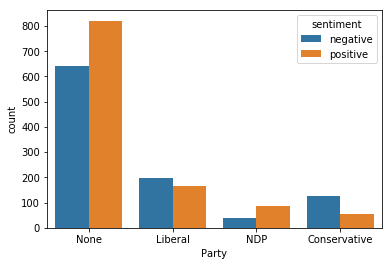

In [89]:
import seaborn as sns
sns.countplot(x = d.Party , hue = d.sentiment)

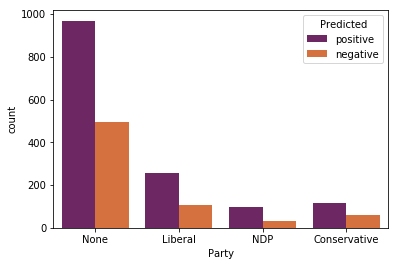

In [90]:
sns.countplot(x = d.Party , hue = d.Predicted, palette= "inferno")

From the above two plots, it can be seen that our model did a pretty decent job in predicting the sentiments of the election tweets. Our election tweet model predicted the sentiments really good for Liberals and NDP where as it didn't do a great job with the Conservatives.

## Suggested Improvements on increasing the accuracy of Election Tweet model:


The model could be trained with domain specific dataset rather than a generic dataset to improve the model prediction in that domain. This idea is tested out in the code below, training the logistic regression model using the Election tweets. Which gave a prediction accuracy of around 70% without parameter tuning and N-grams tuning.

The typos and informal lauguage adds noise to the data. These could be improved by applying spell correction to each text in the dataset, which would help eliminate words with extremely low frequency. This improvement was previously attemped with the python autocorrect library however was abondaned due to very high computational cost.

Election Tweet  Model Test Accuracy: 69.19999999999999%

              precision    recall  f1-score   support

    negative       0.69      0.62      0.65       299
    positive       0.69      0.75      0.72       341

   micro avg       0.69      0.69      0.69       640
   macro avg       0.69      0.69      0.69       640
weighted avg       0.69      0.69      0.69       640



<Figure size 432x288 with 0 Axes>

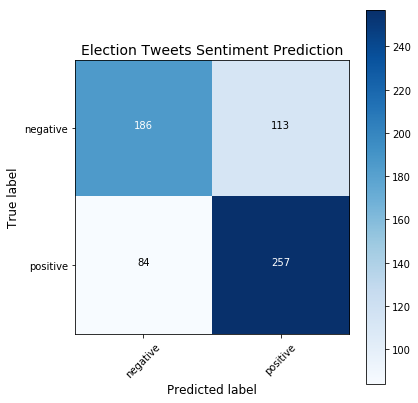

In [91]:
model_election=LogisticRegression()
cv_2=CountVectorizer()
election_tweet_bag=cv_2.fit_transform(election_tweets_vec.text)
election_fit = TfidfTransformer().fit(election_tweet_bag)
election_trans = election_fit.transform(election_tweet_bag)
election_trans.shape

X_election=election_trans
Y_election=election_tweets_vec['sentiment']

X_train_election, X_test_election, Y_train_election, Y_test_election = train_test_split(X_election,Y_election,test_size=0.3, random_state=100)

model_election.fit(X_train_election,Y_train_election)

y_pred_election_2=model_election.predict(X_test_election)

ticklabel=election_tweets_vec.sentiment.unique()
cm=metrics.confusion_matrix(Y_test_election, y_pred_election_2, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Election Tweets Sentiment Prediction', fs=(6,6), font_size=14)
print ('Election Tweet  Model Test Accuracy: '+str(round(accuracy_score(Y_test_election, y_pred_election_2),3)*100)+'%'+'\n')
print(classification_report(Y_test_election, y_pred_election_2))

From the above results, we can see that the model prepared using election tweets was able to give a better accuracy of almost 70% instead of using the model prepared from generic tweets dataset. Further hypertuning the ngrams and model parameters could help us get a better accuracy.